# Spectral fitting example (Crab)

**To run this, you need the following files, which can be downloaded using the first few cells of this notebook:**
- orientation file (20280301_3_month.ori)       
- binned data (crab_bkg_binned_data.hdf5, crab_binned_data.hdf5, & bkg_binned_data.hdf5)     
- detector response (SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip)     

**The binned data are simulations of the Crab Nebula and albedo photon background produced using the COSI SMEX mass model. The detector response needs to be unzipped before running the notebook.**

This notebook fits the spectrum of a Crab simulated using MEGAlib and combined with background.

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple datasets from different instruments to be used coherently to fit the parameters of source model. A source model typically consists of a list of sources with parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the expected counts given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed up to a scaling factor. Finally, we will fit a Band function:

$$
f(x) = K \begin{cases} \left(\frac{x}{E_{piv}}\right)^{\alpha} \exp \left(-\frac{(2+\alpha)
       * x}{x_{p}}\right) & x \leq (\alpha-\beta) \frac{x_{p}}{(\alpha+2)} \\ \left(\frac{x}{E_{piv}}\right)^{\beta}
       * \exp (\beta-\alpha)\left[\frac{(\alpha-\beta) x_{p}}{E_{piv}(2+\alpha)}\right]^{\alpha-\beta}
       * &x>(\alpha-\beta) \frac{x_{p}}{(\alpha+2)} \end{cases}
$$

where $K$ (normalization), $\alpha$ & $\beta$ (spectral indeces), and $x_p$ (peak energy) are the free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = B*b_i + s_i(\mathbf{x})
$$

where $B*b_i$ are the estimated counts due to background in each bin with $B$ the amplitude and $b_i$ the shape of the background, and $s_i$ are the corresponding expected counts from the source, the goal is then to find the values of $\mathbf{x} = [K, \alpha, \beta, x_p]$ and $B$ that maximize $\mathcal{L}$. These are the best estimations of the parameters.

The final module needs to also fit the time-dependent background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [1]:
from cosipy import COSILike, test_data, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from cosipy.util import fetch_wasabi_file

from scoords import SpacecraftFrame

from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic

import numpy as np
import matplotlib.pyplot as plt

from threeML import Band, PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter

from pathlib import Path

import os

12:03:40 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=916286;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=215945;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=868229;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=764392;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=919383;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=286569;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=402464;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=161328;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=200604;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=500344;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=943578;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=139722;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=882185;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=365193;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=588991;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=483700;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

12:03:40 INFO      Starting 3ML!                                                                     ]8;id=534169;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=474409;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=765631;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=407033;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=987302;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=770994;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=670603;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=174077;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=60557;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=407332;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=541693;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=894858;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=847328;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=707179;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=853968;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=45582;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=982551;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=171931;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=958192;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=870302;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

12:03:41 WARNING   No fermitools installed                                              ]8;id=138869;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=412603;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

12:03:41 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=828564;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=463928;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=215262;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=583062;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=752545;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=955651;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Download and read in binned data

Define the path to the directory containing the data, detector response, orientation file, and yaml files if they have already been downloaded, or the directory to download the files into

In [2]:
data_path = Path("/path/to/files")

Download the orientation file (684.38 MB)

In [3]:
fetch_wasabi_file('COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori', output=str(data_path / '20280301_3_month.ori'))

Download the binned Crab+background data (99.16 MB)

In [5]:
fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/crab_spectral_fit_galactic_frame/crab_bkg_binned_data.hdf5', output=str(data_path / 'crab_bkg_binned_data.hdf5'))

Download the binned Crab data (13.16 MB)

In [7]:
fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/crab_spectral_fit_galactic_frame/crab_binned_data.hdf5', output=str(data_path / 'crab_binned_data.hdf5'))

Download the binned background data (89.10 MB)

In [9]:
fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/crab_spectral_fit_galactic_frame/bkg_binned_data.hdf5', output=str(data_path / 'bkg_binned_data.hdf5'))

Download the response file (839.62 MB). This needs to be unzipped before running the rest of the notebook

In [10]:
fetch_wasabi_file('COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip', output=str(data_path / 'SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip'))

Read in the spacecraft orientation file

In [4]:
sc_orientation = SpacecraftFile.parse_from_file(data_path / "20280301_3_month.ori")

Create BinnedData objects for the Crab only, Crab+background, and background only. The Crab only simulation is not used for the spectral fit, but can be used to compare the fitted spectrum to the source simulation

In [5]:
crab = BinnedData(data_path / "crab.yaml")
crab_bkg = BinnedData(data_path / "crab.yaml")
bkg = BinnedData(data_path / "background.yaml")

Load binned .hdf5 files

In [6]:
crab.load_binned_data_from_hdf5(binned_data=data_path / "crab_binned_data.hdf5")
crab_bkg.load_binned_data_from_hdf5(binned_data=data_path / "crab_bkg_binned_data.hdf5")
bkg.load_binned_data_from_hdf5(binned_data=data_path / "bkg_binned_data.hdf5")

Define the path to the detector response

In [7]:
dr = str(data_path / "SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5") # path to detector response

## Perform spectral fit

Set background parameter, which is used to fit the amplitude of the background, and instantiate the COSI 3ML plugin

In [8]:
bkg_par = Parameter("background_cosi",                                         # background parameter
                     1,                                                        # initial value of parameter
                     min_value=0,                                              # minimum value of parameter
                     max_value=5,                                              # maximum value of parameter
                     delta=0.05,                                               # initial step used by fitting engine
                     desc="Background parameter for cosi")

cosi = COSILike("cosi",                                                        # COSI 3ML plugin
                 dr = dr,                                                      # detector response
                 data = crab_bkg.binned_data.project('Em', 'Phi', 'PsiChi'),   # data (source+background)
                 bkg = bkg.binned_data.project('Em', 'Phi', 'PsiChi'),         # background model 
                 sc_orientation = sc_orientation,                              # spacecraft orientation
                 nuisance_param = bkg_par)                                     # background parameter

Define a point source at the known location with a Band function spectrum and add it to the model. The initial values of the Band function parameters are set to the true values used to simulate the source

In [9]:
l = 184.56
b = -5.78

alpha = -1.99
beta = -2.32
E0 = 531. * (alpha - beta) * u.keV
xp = E0 * (alpha + 2) / (alpha - beta)
piv = 500. * u.keV
K = 3.07e-5 / u.cm / u.cm / u.s / u.keV

spectrum = Band()

spectrum.alpha.min_value = -2.14
spectrum.alpha.max_value = 3.0
spectrum.beta.min_value = -5.0
spectrum.beta.max_value = -2.15
spectrum.xp.min_value = 1.0

spectrum.alpha.value = alpha
spectrum.beta.value = beta
spectrum.xp.value = xp.value
spectrum.K.value = K.value
spectrum.piv.value = piv.value

spectrum.xp.unit = xp.unit
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

spectrum.alpha.delta = 0.01
spectrum.beta.delta = 0.01

source = PointSource("source",                     # Name of source (arbitrary, but needs to be unique)
                     l = l,                        # Longitude (deg)
                     b = b,                        # Latitude (deg)
                     spectral_shape = spectrum)    # Spectral model

# Optional: free the position parameters
#source.position.l.free = True
#source.position.b.free = True

model = Model(source)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

12:04:35 WARNING   The current value of the parameter beta (-2.0) was above the new maximum -2.15. ]8;id=444891;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=999475;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#794\794]8;;\

... Calculating point source responses ...



WARNING ErfaWarning: ERFA function "utctai" yielded 7979956 of "dubious year (Note 3)"



--> done (source name : source)
--> all done


Gather all plugins and combine with the model in a JointLikelihood object, then perform maximum likelihood fit

In [10]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = False)

like.fit()

12:05:05 INFO      set the minimizer to minuit                                             ]8;id=102912;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=987128;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

Adding 1e-12 to each bin of the expectation to avoid log-likelihood = -inf.

WARNING IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.



12:05:26 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=737530;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=278840;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

12:05:26 WARNING   The current value of the parameter beta (-2.0) was above the new maximum -2.15. ]8;id=562228;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=53136;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#794\794]8;;\

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(2.857 +/- 0.023) x 10^-5,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,-1.9886 +/- 0.0004,
source.spectrum.main.Band.xp,4.47 -0.17 +0.18,keV
source.spectrum.main.Band.beta,-2.1964 +/- 0.0016,
background_cosi,(9.9193 +/- 0.0020) x 10^-1,


Correlation matrix:

1.00,0.42,-0.61,-0.12,0.05
0.42,1.00,0.45,0.08,-0.03
-0.61,0.45,1.00,0.01,-0.02
-0.12,0.08,0.01,1.00,-0.52
0.05,-0.03,-0.02,-0.52,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-2.612135e+08
total,-2.612135e+08


Values of statistical measures:

,statistical measures
AIC,-5.224270e+08
BIC,-5.224270e+08


(                                    value  negative_error  positive_error  \
 source.spectrum.main.Band.K      0.000029   -2.272835e-07    2.278935e-07   
 source.spectrum.main.Band.alpha -1.988617   -3.560944e-04    3.585775e-04   
 source.spectrum.main.Band.xp     4.473464   -1.691279e-01    1.784522e-01   
 source.spectrum.main.Band.beta  -2.196416   -1.564268e-03    1.565798e-03   
 background_cosi                  0.991932   -1.915462e-04    1.937451e-04   
 
                                         error             unit  
 source.spectrum.main.Band.K      2.275885e-07  1 / (cm2 keV s)  
 source.spectrum.main.Band.alpha  3.573359e-04                   
 source.spectrum.main.Band.xp     1.737900e-01              keV  
 source.spectrum.main.Band.beta   1.565033e-03                   
 background_cosi                  1.926456e-04                   ,
        -log(likelihood)
 cosi      -2.612135e+08
 total     -2.612135e+08)

## Error propagation and plotting (Band function)

Define Band function spectrum injected into MEGAlib

In [11]:
alpha_inj = -1.99
beta_inj = -2.32
E0_inj = 531. * (alpha_inj - beta_inj) * u.keV
xp_inj = E0_inj * (alpha_inj + 2) / (alpha_inj - beta_inj)
piv_inj = 100. * u.keV
K_inj = 7.56e-4 / u.cm / u.cm / u.s / u.keV

spectrum_inj = Band()

spectrum_inj.alpha.min_value = -2.14
spectrum_inj.alpha.max_value = 3.0
spectrum_inj.beta.min_value = -5.0
spectrum_inj.beta.max_value = -2.15
spectrum_inj.xp.min_value = 1.0

spectrum_inj.alpha.value = alpha_inj
spectrum_inj.beta.value = beta_inj
spectrum_inj.xp.value = xp_inj.value
spectrum_inj.K.value = K_inj.value
spectrum_inj.piv.value = piv_inj.value

spectrum_inj.xp.unit = xp_inj.unit
spectrum_inj.K.unit = K_inj.unit
spectrum_inj.piv.unit = piv_inj.unit

12:06:33 WARNING   The current value of the parameter beta (-2.0) was above the new maximum -2.15. ]8;id=26512;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=246007;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#794\794]8;;\

The summary of the results above tell you the optimal values of the parameters, as well as the errors. Propogate the errors to the "evaluate_at" method of the spectrum

In [12]:
results = like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["source"].parameters.values()
              if par.free}

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["source"])

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Band.K,(2.857 +/- 0.023) x 10^-5,1 / (cm2 keV s)
source.spectrum.main.Band.alpha,-1.9886 +/- 0.0004,
source.spectrum.main.Band.xp,4.47 -0.17 +0.18,keV
source.spectrum.main.Band.beta,-2.1964 +/- 0.0016,
background_cosi,(9.9193 +/- 0.0020) x 10^-1,


Correlation matrix:

1.00,0.42,-0.61,-0.12,0.05
0.42,1.00,0.45,0.08,-0.03
-0.61,0.45,1.00,0.01,-0.02
-0.12,0.08,0.01,1.00,-0.52
0.05,-0.03,-0.02,-0.52,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-2.612135e+08
total,-2.612135e+08


Values of statistical measures:

,statistical measures
AIC,-5.224270e+08
BIC,-5.224270e+08


None


12:06:34 WARNING   The current value of the parameter beta (-2.0) was above the new maximum -2.15. ]8;id=840959;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=587231;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#794\794]8;;\

         WARNING   The current value of the parameter beta (-2.0) was above the new maximum -2.15. ]8;id=521892;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=431406;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#794\794]8;;\

         WARNING   The current value of the parameter beta (-2.0) was above the new maximum -2.15. ]8;id=402878;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=82481;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#794\794]8;;\

  * source (point source):
    * position:
      * l:
        * value: 184.56
        * desc: Galactic longitude
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * b:
        * value: -5.78
        * desc: Galactic latitude
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Band:
          * K:
            * value: 2.8565585663971596e-05
            * desc: Differential flux at the pivot energy
            * min_value: 1.0e-99
            * max_value: null
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * alpha:
            * value: -1.9886166208617622
            * desc: low-energy photon index
            * min_value: -2.14
            * max_value: 3.0
            * unit: ''
            * is_normalization: false
          * xp:
            * value: 4.473463779563324
     

Evaluate the flux and errors at a range of energies for the fitted and injected spectra, and the simulated source flux

In [13]:
energy = np.geomspace(100*u.keV,10*u.MeV).to_value(u.keV)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)
flux_inj = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    flux_inj[i] = spectrum_inj.evaluate_at(e)
    
binned_energy_edges = crab.binned_data.axes['Em'].edges.value
binned_energy = np.array([])
bin_sizes = np.array([])

for i in range(len(binned_energy_edges)-1):
    binned_energy = np.append(binned_energy, (binned_energy_edges[i+1] + binned_energy_edges[i]) / 2)
    bin_sizes = np.append(bin_sizes, binned_energy_edges[i+1] - binned_energy_edges[i])

expectation = cosi._expected_counts['source']

Plot the fitted and injected spectra

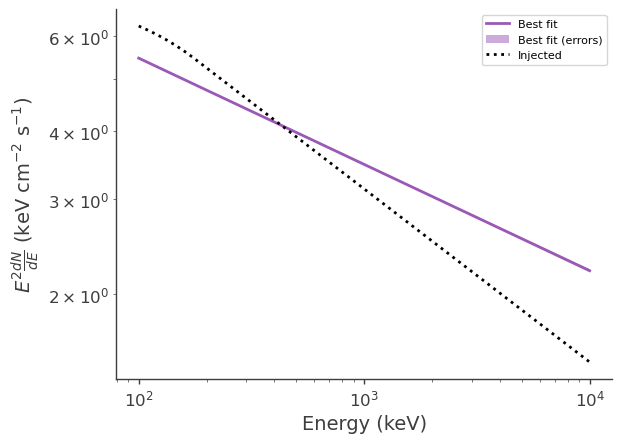

In [14]:
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Best fit")
ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Best fit (errors)")
ax.plot(energy, energy*energy*flux_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ (keV cm$^{-2}$ s$^{-1}$)")

ax.legend()

Plot the fitted spectrum convolved with the response, as well as the simulated source counts

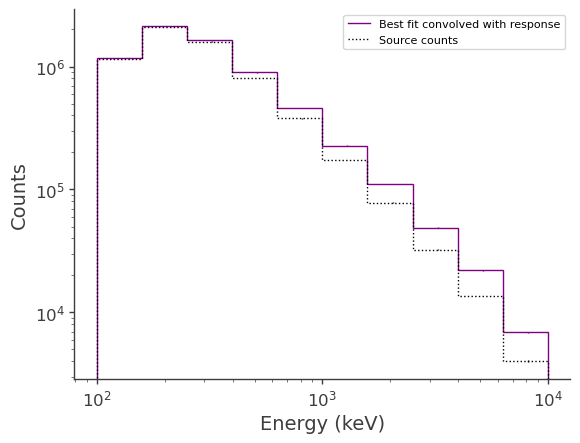

In [15]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents, yerr=np.sqrt(expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(crab.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Source counts")
ax.errorbar(binned_energy, crab.binned_data.project('Em').todense().contents, yerr=np.sqrt(crab.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

Plot the fitted spectrum convolved with the response plus the fitted background, as well as the simulated source+background counts

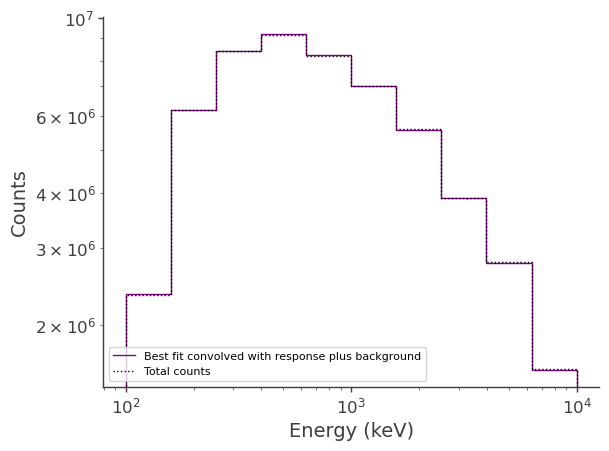

In [16]:
fig,ax = plt.subplots()

ax.stairs(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), binned_energy_edges, color='purple', label = "Best fit convolved with response plus background")
ax.errorbar(binned_energy, expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents), yerr=np.sqrt(expectation.project('Em').todense().contents+(bkg_par.value * bkg.binned_data.project('Em').todense().contents)), color='purple', linewidth=0, elinewidth=1)
ax.stairs(crab_bkg.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Total counts")
ax.errorbar(binned_energy, crab_bkg.binned_data.project('Em').todense().contents, yerr=np.sqrt(crab_bkg.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()